# MedMINIST-Pneumonia

Il seguente notebook illustra vari modelli per l'individuazione di soggetti positivi alla polmonite a partire da radiografie del torace in formato MNIST.


In [55]:
import tensorflow as tf

assert tf.__version__ >= "2.16"

import keras_tuner as kt
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
import os

from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    make_scorer,
    f1_score,
    accuracy_score,
    precision_recall_fscore_support,
    ConfusionMatrixDisplay,
)
from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.utils.class_weight import compute_class_weight

from imblearn.over_sampling import RandomOverSampler, SMOTE

tf.keras.utils.set_random_seed(42)  # set all the seeds (Python, Keras, Tensorflow and NumPy)
# tf.config.experimental.enable_op_determinism() # cant'use with some layers in CNN like MaxPool
os.environ["TF_CUDNN_DETERMINISTIC"] = "1"  # does not affect the model results

In [2]:
# plot functions

plt.style.use("fivethirtyeight")
plt.rcParams["font.family"] = "sans-serif"
plt.rcParams["font.serif"] = "Ubuntu"
plt.rcParams["font.monospace"] = "Ubuntu Mono"
plt.rcParams["font.size"] = 10
plt.rcParams["axes.labelsize"] = 10
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams["axes.titlesize"] = 10
plt.rcParams["xtick.labelsize"] = 8
plt.rcParams["ytick.labelsize"] = 8
plt.rcParams["legend.fontsize"] = 10
plt.rcParams["figure.titlesize"] = 12
plt.rcParams["image.cmap"] = "jet"
plt.rcParams["image.interpolation"] = "none"
plt.rcParams["figure.figsize"] = (16, 8)
plt.rcParams["lines.linewidth"] = 2
plt.rcParams["lines.markersize"] = 8


def plot_measure(history_train, history_test, title="", xticks=None):
    plt.figure(figsize=(12, 8))
    plt.plot(history_train, marker="o", markersize=5, label="Train")
    plt.plot(history_test, marker="o", markersize=5, label="Validation")
    plt.legend()
    if xticks is None:
        plt.gca().xaxis.set_major_locator(plt.NullLocator())
    else:
        ax = plt.subplot(111)
        ax.set_xlim(xticks[0], xticks[-1])
        plt.xticks(xticks)
    plt.title(title)
    plt.show()


def plot_confusion_matrix(train_labels, predictions_train):
    plt.figure(figsize=(12, 6))
    disp = ConfusionMatrixDisplay.from_predictions(train_labels, predictions_train, normalize="true", cmap="Blues")
    disp.figure_.suptitle("Confusion Matrix")
    plt.grid(None)
    plt.show()

In [3]:
# utilis function


def print_accuracy_scores(train_labels, test_labels, predictions_train_model, predictions_test_model):
    acc_train = accuracy_score(train_labels, predictions_train_model)
    acc_test = accuracy_score(test_labels, predictions_test_model)
    print("Training set accuracy:   {:.3f}".format(acc_train))
    print("Test set accuracy:       {:.3f}".format(acc_test))


def print_stats(labels, predictions, title):
    meas = precision_recall_fscore_support(labels, predictions, average=None, zero_division=np.nan)
    print(title)
    for i in range(2):
        print(
            "Class {0:d}: precision={1:5.3f}, recall={2:5.3f}, f1_score={3:5.3f}".format(
                i, meas[0][i], meas[1][i], meas[2][i]
            )
        )


def train_validation_test_split(images, labels, test_val_size, verbose=False):
    train_images, test_val_images, train_labels, test_val_labels = train_test_split(
        images, labels, test_size=test_val_size, random_state=42
    )
    val_images, test_images, val_labels, test_labels = train_test_split(
        test_val_images, test_val_labels, test_size=0.5, random_state=42
    )

    if verbose:
        try:
            print(
                f"Shape of training set of images:    {train_images.shape}\t\timages of size {train_images.shape[1]}x{train_images.shape[2]}"
            )
            print(
                f"Shape of validation set of images:  {val_images.shape}\t\timages of size {val_images.shape[1]}x{val_images.shape[2]}"
            )
            print(
                f"Shape of test set of images:        {test_images.shape}\t\timages of size {test_images.shape[1]}x{test_images.shape[2]}"
            )
            nb_classes = np.unique(train_labels).shape[0]
            print(f"Number of classes: {nb_classes}")
        except IndexError:
            print(f"Shape of training set of images:    {train_images.shape}")
            print(f"Shape of validation set of images:  {val_images.shape}")
            print(f"Shape of test set of images:        {test_images.shape}")
            nb_classes = np.unique(train_labels).shape[0]
            print(f"Number of classes: {nb_classes}")

    return train_images, train_labels, val_images, val_labels, test_images, test_labels

In [4]:
# load dataset

X = np.load("pneumonia_images.npy")
y = (np.load("pneumonia_labels.npy")).ravel()

if len(X) != len(y):
    raise ValueError("Numbers of images and labels do not match")

print(f"The dataset is composed by {X.shape[0]} images {X.shape[1]}x{X.shape[2]}")

bin_count = np.bincount(y)
if len(bin_count) != 2:
    raise ValueError("Labels must be 0 or 1")

print("Negative examples: ", bin_count[0])
print("Positive examples: ", bin_count[1])

if bin_count[0] != bin_count[1]:
    print("Imbalanced Dataset")
else:
    print("Balanced Dataset")

x_negative = next((i for i, x in enumerate(X) if y[i] == 0), None)
x_positive = next((i for i, x in enumerate(X) if y[i] == 1), None)

The dataset is composed by 5232 images 28x28
Negative examples:  1349
Positive examples:  3883
Imbalanced Dataset


## Il dataset

Il dataset viene fornite tramite due file .npy contenti le immagini e le rispettive etichette. Data la mancaza di documentazione si assume, banalmente, l'etichetta 0 come negativo e 1 come positivo.
Dall'analisi del dataset è evidente uno sbilanciamento tra le classi:

- 1349 elementi negativi;
- 3883 elementi positivi.


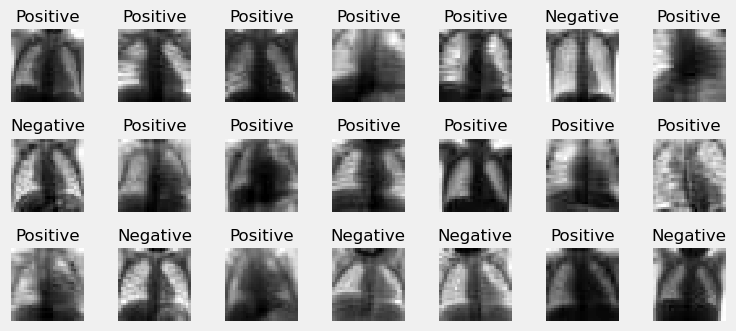

In [5]:
# print examples

n_rows = 3
n_cols = 7
titles = ["Negative", "Positive"]
plt.figure(figsize=(n_cols * 1.2, n_rows * 1.2))
for row in range(n_rows):
    for col in range(n_cols):
        index = n_cols * row + col
        plt.subplot(n_rows, n_cols, index + 1)
        plt.imshow(X[index], cmap="binary", interpolation="nearest")
        plt.axis("off")
        plt.title(titles[y[index]], fontsize=12)
plt.subplots_adjust(wspace=0.2, hspace=0.5)
plt.show()

## Istogrammi

Il primo approccio applicato è quello degli istogrammi della tonalità di grigio. Da una breve visione delle immagine è evidente una tendenza al bianco delle radiografie dei soggetti malati. Questa è un'operazione di riduzione delle feature, dai 784 pixel di cui è composta l'immagine si passa al numero dei bin.
Si è deciso di procedere all'analisi su istogrammi da 8, 16, 32 e 64 bin per i seguenti modelli:

- Logistic Regression;
- Random Forest.

Per quando riguarda lo sbilanciamento tra le classi si è deciso di confrontare 3 soluzioni possibili:

- aggiungere un peso agli elementi delle classi (Weighted);
- Oversampling;
- SMOTE.

Il primo viene offerto da  _scikit-learn_  tramite il parametro _class_weight_; è sufficiente passare a questo parametro la stringa "balanced".

L'oversamplig è una tecnica che consiste nel bilanciare le classi tramite la duplicazione degli elementi della classe minoritaria.

SMOTE (Synthetic Minority Over-sampling Technique) è un metodo di oversampling che crea elementi sintetici tramite interpolazione dei vicini, nello spazio delle feature, degli elementi della classe minoritaria.

Per Oversampling e SMOTE viene utilizzato il paccheto Imbalanced Learning.

La ricerca degli iperparametri viene effetuata tramite Keras Tuner utilizzando SklearnTuner e il GridSearchOracle. L'80% del dataset viene destinato al Training Set e il rimanente al Test Set. Tutto il Trainig Set viene utilizzato per il tuning degli iperparametri che usa una cross validation, StrafiedKFold, con 5 fold. Come indicato dalla documentazione di Keras Tuner, una volta identificati i migliori iperparametri viene effetuato un nuovo training su tutto il Training Set.


In [6]:
def extract_histogram(
    image,
    color_space,
    channels=(0, 1, 2),
    bins=(8, 8, 8),
    range=(0, 256, 0, 256, 0, 256),
):
    if color_space is None:
        cvt_img = image
    else:
        cvt_img = cv2.cvtColor(image, color_space)
    hist = cv2.calcHist([cvt_img], channels, None, bins, range)
    cv2.normalize(hist, hist)
    return hist.flatten()


def get_histograms(dataset, color_space, channels, bins, channels_range):
    histograms = []
    for x in dataset:
        hist = extract_histogram(x, color_space, channels, bins, channels_range)
        histograms.append(hist)
    return histograms


def ranges(N, nb):
    step = N / nb
    return ["{},{}".format(round(step * i), round(step * (i + 1))) for i in range(nb)]

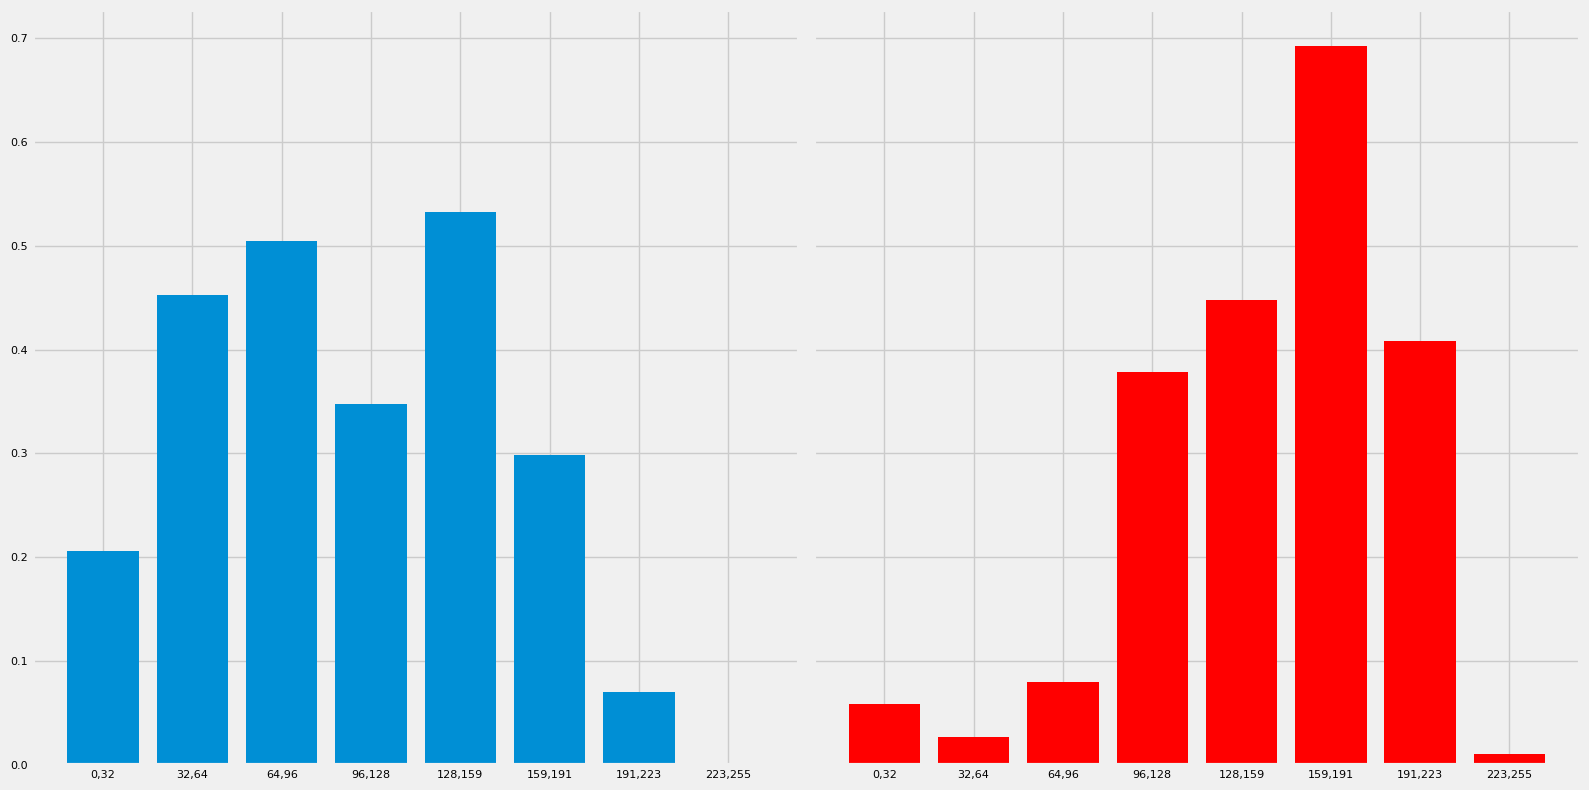

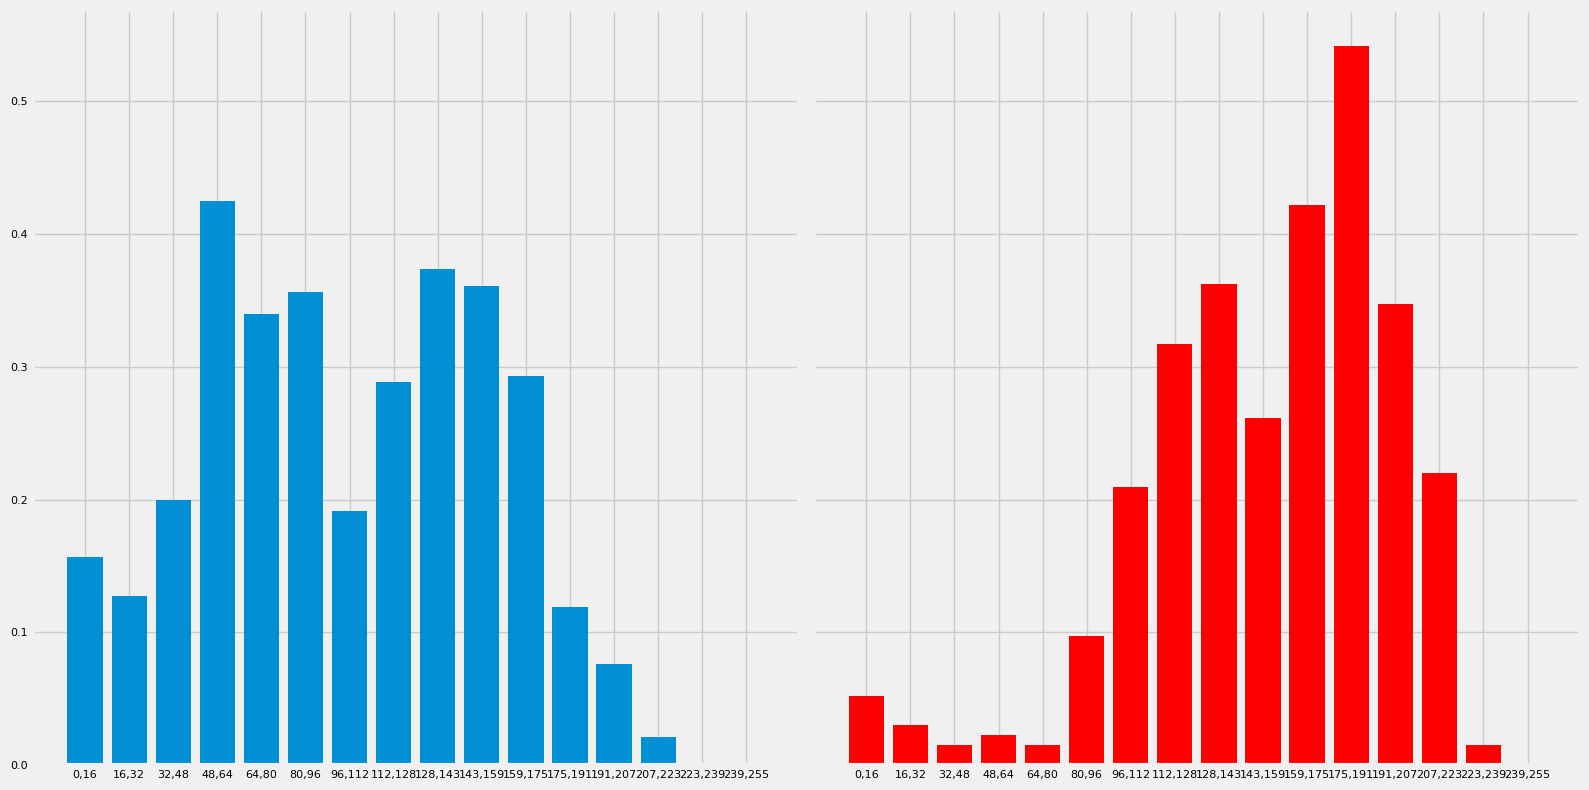

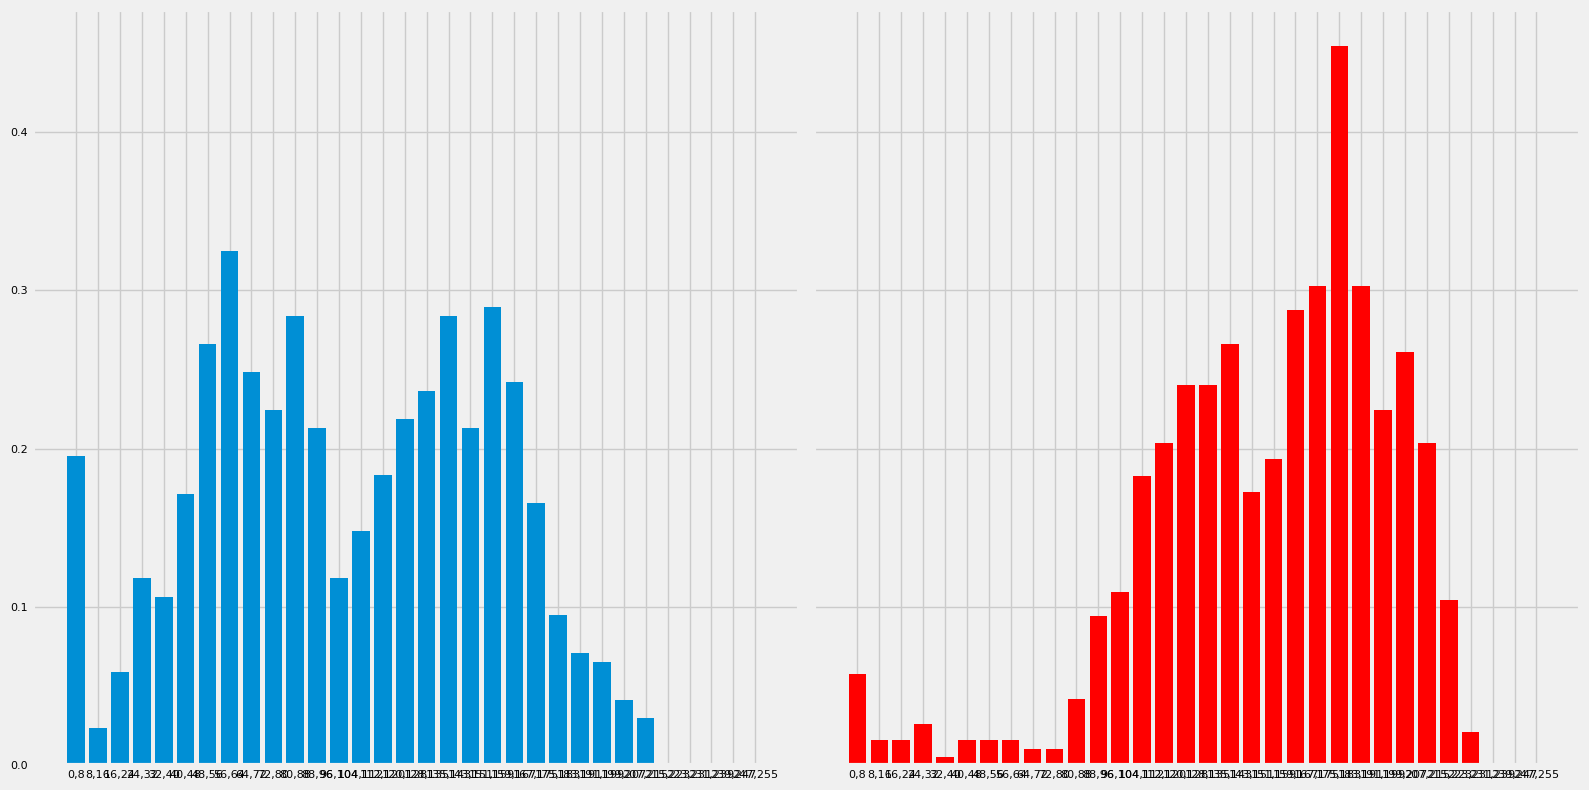

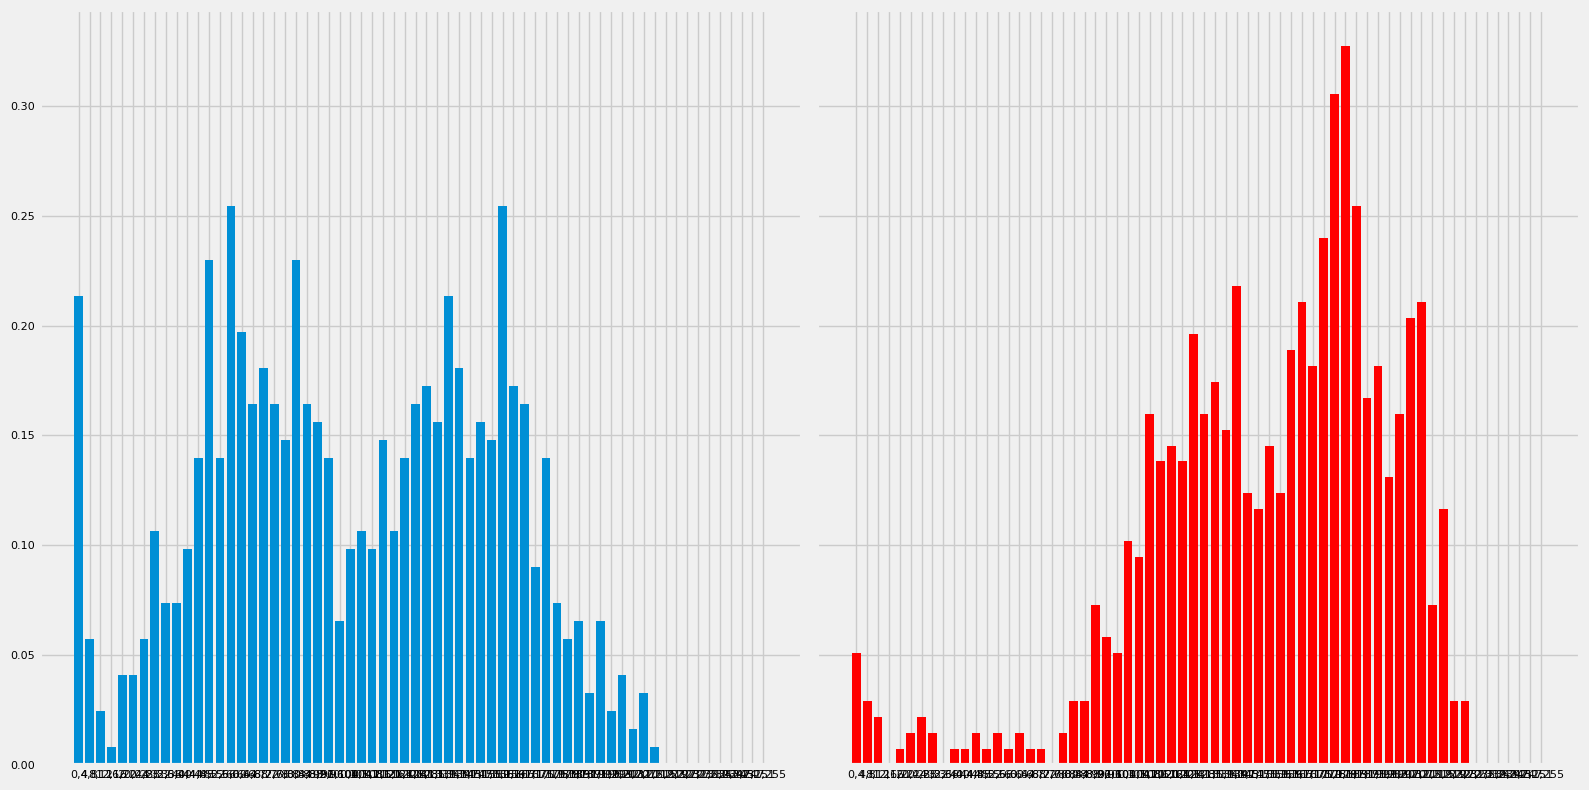

In [7]:
# negative
hist8bins_negative = extract_histogram(X[x_negative], None, (0,), (8,), (0, 256))
hist16bins_negative = extract_histogram(X[x_negative], None, (0,), (16,), (0, 256))
hist32bins_negative = extract_histogram(X[x_negative], None, (0,), (32,), (0, 256))
hist64bins_negative = extract_histogram(X[x_negative], None, (0,), (64,), (0, 256))

# positive
hist8bins__positive = extract_histogram(X[x_positive], None, (0,), (8,), (0, 256))
hist16bins_positive = extract_histogram(X[x_positive], None, (0,), (16,), (0, 256))
hist32bins_positive = extract_histogram(X[x_positive], None, (0,), (32,), (0, 256))
hist64bins_positive = extract_histogram(X[x_positive], None, (0,), (64,), (0, 256))

# 8 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 8), hist8bins_negative)
axs[1].bar(ranges(255, 8), hist8bins__positive, color="red")
plt.show()

# 16 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 16), hist16bins_negative)
axs[1].bar(ranges(255, 16), hist16bins_positive, color="red")
plt.show()

# 32 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 32), hist32bins_negative)
axs[1].bar(ranges(255, 32), hist32bins_positive, color="red")
plt.show()

# 64 bins
fig, axs = plt.subplots(1, 2, sharey=True, tight_layout=True)
axs[0].bar(ranges(255, 64), hist64bins_negative)
axs[1].bar(ranges(255, 64), hist64bins_positive, color="red")
plt.show()

In [8]:
# histogram dataset

bins_8 = np.array(get_histograms(X, None, (0,), (8,), (0, 256)))
bins_16 = np.array(get_histograms(X, None, (0,), (16,), (0, 256)))
bins_32 = np.array(get_histograms(X, None, (0,), (32,), (0, 256)))
bins_64 = np.array(get_histograms(X, None, (0,), (64,), (0, 256)))

ros = RandomOverSampler(random_state=42)
bins_8_over, y_over = ros.fit_resample(bins_8, y)
bins_16_over, y_over = ros.fit_resample(bins_16, y)
bins_32_over, y_over = ros.fit_resample(bins_32, y)
bins_64_over, y_over = ros.fit_resample(bins_64, y)

sm = SMOTE(random_state=42)
bins_8_smote, y_smote = sm.fit_resample(bins_8, y)
bins_16_smote, y_smote = sm.fit_resample(bins_16, y)
bins_32_smote, y_smote = sm.fit_resample(bins_32, y)
bins_64_smote, y_smote = sm.fit_resample(bins_64, y)

Dato il problema medico si è posta l'attenzione non sull'accuracy, ma sulla recall della classe 1, i positivi, poichè è auspicabicale l'individuazione del malato a discapito di un sano che venga classificato erroneamente. Dato che il tuning degli iperparametri cercando la massimizzazione della recall della classe 1 portava spesso ad assegnare tutti gli elementi a quella classe si è prefirito utilizzare f1_score come metrica da massimizzare.

Dai tre metodi di bilanciamento ci si aspettato diversi risultati nelle metriche precision, recall e F1. Per esempio, è noto che SMOTE tende a favorire la classe minoritaria, in questo caso è quella meno interessante per la nostra classificazione.

Si ipotizza inoltre un miglioramento al crescre dei bin.


In [9]:
scorer = make_scorer(f1_score, pos_label=1, labels=[0, 1])

### Logistic Regression

Per la regressione logistica, la ricerca si è concentrata sulla penalità applicata al modello e sul suo peso.

Utilizzando il solver **saga**, tra i tipi di regolarizzazione è possibile scegliere tra L1 (Lasso), L2 (Ridge) ed Elastic-Net. Elastic-Net permette di utlizzare L1 e L2 insieme pesando le 2 componenti tramite il parametro _l1_ratio_. Il valore di _l1_ratio_ è compreso tra 0 e 1, dove 0 corrisponde a L2 e 1 a L1.

Gli iperparametri esaminati durante il tuning sono quindi 2:

- **C**, l'inverso del peso della penalità;
- **l1_ratio**.


In [10]:
def log_reg(project_name, data, labels, title, class_weight=None):

    def build_logistic_regression(hp):
        model = LogisticRegression(
            n_jobs=-1,
            random_state=42,
            class_weight=class_weight,
            C=hp.Choice("C", [0.00001, 0.0001, 0.001, 0.01, 0.1, 1.0]),
            solver="saga",
            penalty="elasticnet",
            l1_ratio=hp.Choice("l1_ratio", [0.0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0]),
            max_iter=200,
        )
        return model

    tuner = kt.tuners.SklearnTuner(
        oracle=kt.oracles.GridSearchOracle(objective=kt.Objective("score", "max")),
        scoring=scorer,
        hypermodel=build_logistic_regression,
        cv=StratifiedKFold(5),
        project_name=project_name,
    )

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    tuner.search(X_train, y_train)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\n{title}\n")

    print("Best C: ", best_hps.get("C"))
    print("Best l1_ratio: ", best_hps.get("l1_ratio"))

    print()

    model0 = tuner.hypermodel.build(best_hps)
    model0.fit(X_train, y_train)

    predictions_test = model0.predict(X_test)
    predictions_train = model0.predict(X_train)

    print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
    print_stats(y_train, predictions_train, "Training set")
    print_stats(y_test, predictions_test, "Test set")

In [11]:
log_reg(
    "tuners/log_reg_hist_8bins_weighted",
    bins_8,
    y,
    "Logistic Regression 8 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_8bins_weighted/tuner0.json

Logistic Regression 8 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.810
Test set accuracy:       0.796
Training set
Class 0: precision=0.594, recall=0.846, f1_score=0.698
Class 1: precision=0.937, recall=0.797, f1_score=0.862
Test set
Class 0: precision=0.568, recall=0.808, f1_score=0.667
Class 1: precision=0.924, recall=0.792, f1_score=0.853


In [12]:
log_reg(
    "tuners/log_reg_hist_8bins_over",
    bins_8_over,
    y_over,
    "Logistic Regression 8 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_8bins_over/tuner0.json

Logistic Regression 8 bins oversampling

Best C:  1.0
Best l1_ratio:  0.9

Training set accuracy:   0.817
Test set accuracy:       0.817
Training set
Class 0: precision=0.800, recall=0.843, f1_score=0.821
Class 1: precision=0.837, recall=0.793, f1_score=0.814
Test set
Class 0: precision=0.815, recall=0.835, f1_score=0.825
Class 1: precision=0.820, recall=0.798, f1_score=0.809


In [13]:
log_reg(
    "tuners/log_reg_hist_8bins_smote",
    bins_8_smote,
    y_smote,
    "Logistic Regression 8 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_8bins_smote/tuner0.json

Logistic Regression 8 bins SMOTE

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.822
Test set accuracy:       0.819
Training set
Class 0: precision=0.805, recall=0.845, f1_score=0.825
Class 1: precision=0.840, recall=0.798, f1_score=0.819
Test set
Class 0: precision=0.814, recall=0.840, f1_score=0.827
Class 1: precision=0.824, recall=0.795, f1_score=0.809


In [14]:
log_reg(
    "tuners/log_reg_hist_16bins_weighted",
    bins_16,
    y,
    "Logistic Regression 16 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_16bins_weighted/tuner0.json

Logistic Regression 16 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.832
Test set accuracy:       0.818
Training set
Class 0: precision=0.626, recall=0.869, f1_score=0.728
Class 1: precision=0.947, recall=0.819, f1_score=0.878
Test set
Class 0: precision=0.601, recall=0.834, f1_score=0.698
Class 1: precision=0.935, recall=0.812, f1_score=0.869


In [15]:
log_reg(
    "tuners/log_reg_hist_16bins_over",
    bins_16_over,
    y_over,
    "Logistic Regression 16 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_16bins_over/tuner0.json

Logistic Regression 16 bins oversampling

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.839
Test set accuracy:       0.838
Training set
Class 0: precision=0.821, recall=0.862, f1_score=0.841
Class 1: precision=0.857, recall=0.815, f1_score=0.836
Test set
Class 0: precision=0.835, recall=0.857, f1_score=0.846
Class 1: precision=0.843, recall=0.819, f1_score=0.831


In [16]:
log_reg(
    "tuners/log_reg_hist_16bins_smote",
    bins_16_smote,
    y_smote,
    "Logistic Regression 16 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_16bins_smote/tuner0.json

Logistic Regression 16 bins SMOTE

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.843
Test set accuracy:       0.848
Training set
Class 0: precision=0.823, recall=0.870, f1_score=0.846
Class 1: precision=0.865, recall=0.816, f1_score=0.840
Test set
Class 0: precision=0.839, recall=0.873, f1_score=0.856
Class 1: precision=0.858, recall=0.822, f1_score=0.840


In [17]:
log_reg(
    "tuners/log_reg_hist_32bins_weighted",
    bins_32,
    y,
    "Logistic Regression 32 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_32bins_weighted/tuner0.json

Logistic Regression 32 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.836
Test set accuracy:       0.819
Training set
Class 0: precision=0.633, recall=0.867, f1_score=0.732
Class 1: precision=0.947, recall=0.825, f1_score=0.881
Test set
Class 0: precision=0.603, recall=0.838, f1_score=0.701
Class 1: precision=0.937, recall=0.813, f1_score=0.871


In [18]:
log_reg(
    "tuners/log_reg_hist_32bins_over",
    bins_32_over,
    y_over,
    "Logistic Regression 32 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_32bins_over/tuner0.json

Logistic Regression 32 bins oversampling

Best C:  1.0
Best l1_ratio:  0.9

Training set accuracy:   0.845
Test set accuracy:       0.846
Training set
Class 0: precision=0.827, recall=0.870, f1_score=0.848
Class 1: precision=0.865, recall=0.821, f1_score=0.843
Test set
Class 0: precision=0.842, recall=0.864, f1_score=0.853
Class 1: precision=0.851, recall=0.827, f1_score=0.839


In [19]:
log_reg(
    "tuners/log_reg_hist_32bins_smote",
    bins_32_smote,
    y_smote,
    "Logistic Regression 32 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_32bins_smote/tuner0.json

Logistic Regression 32 bins SMOTE

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.850
Test set accuracy:       0.849
Training set
Class 0: precision=0.833, recall=0.873, f1_score=0.852
Class 1: precision=0.869, recall=0.827, f1_score=0.848
Test set
Class 0: precision=0.845, recall=0.868, f1_score=0.856
Class 1: precision=0.855, recall=0.830, f1_score=0.842


In [20]:
log_reg(
    "tuners/log_reg_hist_64bins_weighted",
    bins_64,
    y,
    "Logistic Regression 64 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/log_reg_hist_64bins_weighted/tuner0.json

Logistic Regression 64 bins weighted

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.836
Test set accuracy:       0.816
Training set
Class 0: precision=0.633, recall=0.871, f1_score=0.733
Class 1: precision=0.948, recall=0.823, f1_score=0.881
Test set
Class 0: precision=0.596, recall=0.842, f1_score=0.698
Class 1: precision=0.938, recall=0.807, f1_score=0.867


In [21]:
log_reg(
    "tuners/log_reg_hist_64bins_over",
    bins_64_over,
    y_over,
    "Logistic Regression 64 bins oversampling",
)

Reloading Tuner from ./tuners/log_reg_hist_64bins_over/tuner0.json

Logistic Regression 64 bins oversampling

Best C:  1.0
Best l1_ratio:  1.0

Training set accuracy:   0.850
Test set accuracy:       0.851
Training set
Class 0: precision=0.831, recall=0.874, f1_score=0.852
Class 1: precision=0.870, recall=0.825, f1_score=0.847
Test set
Class 0: precision=0.840, recall=0.878, f1_score=0.859
Class 1: precision=0.863, recall=0.822, f1_score=0.842


In [22]:
log_reg(
    "tuners/log_reg_hist_64bins_smote",
    bins_64_smote,
    y_smote,
    "Logistic Regression 64 bins SMOTE",
)

Reloading Tuner from ./tuners/log_reg_hist_64bins_smote/tuner0.json

Logistic Regression 64 bins SMOTE

Best C:  1.0
Best l1_ratio:  0.8

Training set accuracy:   0.850
Test set accuracy:       0.846
Training set
Class 0: precision=0.831, recall=0.876, f1_score=0.853
Class 1: precision=0.871, recall=0.825, f1_score=0.847
Test set
Class 0: precision=0.838, recall=0.870, f1_score=0.854
Class 1: precision=0.856, recall=0.820, f1_score=0.838


In tutti i casi è stato selezionato durante il tuning la panalità L1 con il costo minore.

Come ipotizzato, l'aumento del numero di feature ha portato a un miglioramento di tutte le metriche considerate, ma fino a 32 bin.

Per quanto riguarda i tre metodi di bilanciamento, il risultato migliore sulla metrica utilizzata per il tuning è stato ottenuto applicando i pesi alle classi. Tuttavia, l'accuracy è risultata migliore con SMOTE, seguita dall'Oversampling, e infine dalla metodo dei pesi (Weighted).

È importante notare che, nel caso del metodo Weighted, c'è una significativa differenza tra la classe 0 e la classe 1 in termini di Precision e Recall. In tutti i casi, si osserva uno sbilanciamento notevole a favore della classe maggioritaria. Al contrario, con SMOTE si verifica l'effetto opposto come previsto.


### Random Forest

Il numero di parametri offerti da **RandomForestClassifier** è molto più ampio rispetto a quello del modello precedente. Per questo motivo, la ricerca degli iperparametri ottimali è stata limitata ai seguenti tre:

- **n_estimators**: il numero di alberi nella foresta.
- **max_depth**: la profondità massima degli alberi.
- **ccp_alpha**, parametro usato per il Minimal Cost-Complexity Pruning, una tecnica per rimuovere i nodi non foglia sotto una certa soglia di complessità.

Inoltre non viene permessa la formazioni di nodi foglia con un solo elemento.


In [23]:
def rand_forest(
    project_name,
    data,
    labels,
    title,
    class_weight=None,
    n_estimators=[100, 250],
    max_depth=[15, 20, 25],
    ccp_alpha=[0.0005, 0.001, 0.0015, 0.002],
):

    def build_random_forest(hp):
        model = RandomForestClassifier(
            n_estimators=hp.Choice("n_estimators", n_estimators),
            max_depth=hp.Choice("max_depth", max_depth),
            min_samples_leaf=2,
            ccp_alpha=hp.Choice("ccp_alpha", ccp_alpha),
            class_weight=class_weight,
            n_jobs=-1,
            random_state=42,
        )

        return model

    tuner = kt.tuners.SklearnTuner(
        oracle=kt.oracles.GridSearchOracle(objective=kt.Objective("score", "max")),
        scoring=scorer,
        hypermodel=build_random_forest,
        cv=StratifiedKFold(5),
        overwrite=False,
        project_name=project_name,
    )

    X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.2, random_state=42)

    tuner.search(X_train, y_train)

    best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

    print(f"\n{title}\n")

    print("Best n_estimators:       ", best_hps.get("n_estimators"))
    print("Best max_depth:          ", best_hps.get("max_depth"))
    print("Best ccp_alpha:          ", best_hps.get("ccp_alpha"))

    print()

    model0 = tuner.hypermodel.build(best_hps)
    model0.fit(X_train, y_train)

    predictions_test = model0.predict(X_test)
    predictions_train = model0.predict(X_train)

    print_accuracy_scores(y_train, y_test, predictions_train, predictions_test)
    print_stats(y_train, predictions_train, "Training set")
    print_stats(y_test, predictions_test, "Test set")

In [24]:
rand_forest(
    "tuners/rand_forest_hist_8bins_weighted",
    bins_8,
    y,
    "Random Forest 8 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_8bins_weighted/tuner0.json

Random Forest 8 bins weighted

Best n_estimators:        100
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.954
Test set accuracy:       0.874
Training set
Class 0: precision=0.880, recall=0.951, f1_score=0.914
Class 1: precision=0.982, recall=0.955, f1_score=0.968
Test set
Class 0: precision=0.755, recall=0.743, f1_score=0.749
Class 1: precision=0.913, recall=0.918, f1_score=0.916


In [25]:
rand_forest(
    "tuners/rand_forest_hist_8bins_over",
    bins_8_over,
    y_over,
    "Random Forest 8 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_8bins_over/tuner0.json

Random Forest 8 bins oversampling

Best n_estimators:        250
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.952
Test set accuracy:       0.912
Training set
Class 0: precision=0.941, recall=0.964, f1_score=0.953
Class 1: precision=0.964, recall=0.941, f1_score=0.952
Test set
Class 0: precision=0.905, recall=0.926, f1_score=0.916
Class 1: precision=0.920, recall=0.896, f1_score=0.908


In [26]:
rand_forest(
    "tuners/rand_forest_hist_8bins_smote",
    bins_8_smote,
    y_smote,
    "Random Forest 8 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_8bins_smote/tuner0.json

Random Forest 8 bins SMOTE

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.942
Test set accuracy:       0.894
Training set
Class 0: precision=0.936, recall=0.948, f1_score=0.942
Class 1: precision=0.948, recall=0.936, f1_score=0.942
Test set
Class 0: precision=0.907, recall=0.887, f1_score=0.897
Class 1: precision=0.882, recall=0.903, f1_score=0.892


In [27]:
rand_forest(
    "tuners/rand_forest_hist_16bins_weighted",
    bins_16,
    y,
    "Random Forest 16 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_16bins_weighted/tuner0.json

Random Forest 16 bins weighted

Best n_estimators:        250
Best max_depth:           15
Best ccp_alpha:           0.0005

Training set accuracy:   0.960
Test set accuracy:       0.897
Training set
Class 0: precision=0.888, recall=0.969, f1_score=0.926
Class 1: precision=0.989, recall=0.957, f1_score=0.973
Test set
Class 0: precision=0.785, recall=0.815, f1_score=0.800
Class 1: precision=0.937, recall=0.925, f1_score=0.931


In [28]:
rand_forest(
    "tuners/rand_forest_hist_16bins_over",
    bins_16_over,
    y_over,
    "Random Forest 16 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_16bins_over/tuner0.json

Random Forest 16 bins oversampling

Best n_estimators:        250
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.967
Test set accuracy:       0.940
Training set
Class 0: precision=0.955, recall=0.979, f1_score=0.967
Class 1: precision=0.978, recall=0.955, f1_score=0.966
Test set
Class 0: precision=0.923, recall=0.965, f1_score=0.943
Class 1: precision=0.961, recall=0.914, f1_score=0.937


In [29]:
rand_forest(
    "tuners/rand_forest_hist_16bins_smote",
    bins_16_smote,
    y_smote,
    "Random Forest 16 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_16bins_smote/tuner0.json

Random Forest 16 bins SMOTE

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.958
Test set accuracy:       0.918
Training set
Class 0: precision=0.953, recall=0.964, f1_score=0.958
Class 1: precision=0.964, recall=0.953, f1_score=0.959
Test set
Class 0: precision=0.919, recall=0.921, f1_score=0.920
Class 1: precision=0.916, recall=0.914, f1_score=0.915


In [30]:
rand_forest(
    "tuners/rand_forest_hist_32bins_weighted",
    bins_32,
    y,
    "Random Forest 32 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_32bins_weighted/tuner0.json

Random Forest 32 bins weighted

Best n_estimators:        100
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.971
Test set accuracy:       0.893
Training set
Class 0: precision=0.917, recall=0.976, f1_score=0.945
Class 1: precision=0.991, recall=0.969, f1_score=0.980
Test set
Class 0: precision=0.778, recall=0.808, f1_score=0.793
Class 1: precision=0.934, recall=0.922, f1_score=0.928


In [31]:
rand_forest(
    "tuners/rand_forest_hist_32bins_over",
    bins_32_over,
    y_over,
    "Random Forest 32 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_32bins_over/tuner0.json

Random Forest 32 bins oversampling

Best n_estimators:        100
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.972
Test set accuracy:       0.932
Training set
Class 0: precision=0.960, recall=0.984, f1_score=0.972
Class 1: precision=0.984, recall=0.960, f1_score=0.972
Test set
Class 0: precision=0.915, recall=0.958, f1_score=0.936
Class 1: precision=0.952, recall=0.906, f1_score=0.928


In [32]:
rand_forest(
    "tuners/rand_forest_hist_32bins_smote",
    bins_32_smote,
    y_smote,
    "Random Forest 32 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_32bins_smote/tuner0.json

Random Forest 32 bins SMOTE

Best n_estimators:        100
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.968
Test set accuracy:       0.928
Training set
Class 0: precision=0.961, recall=0.974, f1_score=0.968
Class 1: precision=0.974, recall=0.961, f1_score=0.968
Test set
Class 0: precision=0.924, recall=0.938, f1_score=0.931
Class 1: precision=0.932, recall=0.918, f1_score=0.925


In [33]:
rand_forest(
    "tuners/rand_forest_hist_64bins_weighted",
    bins_64,
    y,
    "Random Forest 64 bins weighted",
    "balanced",
)

Reloading Tuner from ./tuners/rand_forest_hist_64bins_weighted/tuner0.json

Random Forest 64 bins weighted

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.978
Test set accuracy:       0.885
Training set
Class 0: precision=0.934, recall=0.983, f1_score=0.958
Class 1: precision=0.994, recall=0.976, f1_score=0.985
Test set
Class 0: precision=0.774, recall=0.774, f1_score=0.774
Class 1: precision=0.923, recall=0.923, f1_score=0.923


In [34]:
rand_forest(
    "tuners/rand_forest_hist_64bins_over",
    bins_64_over,
    y_over,
    "Random Forest 64 bins oversampling",
)

Reloading Tuner from ./tuners/rand_forest_hist_64bins_over/tuner0.json

Random Forest 64 bins oversampling

Best n_estimators:        250
Best max_depth:           20
Best ccp_alpha:           0.0005

Training set accuracy:   0.978
Test set accuracy:       0.936
Training set
Class 0: precision=0.968, recall=0.989, f1_score=0.978
Class 1: precision=0.989, recall=0.967, f1_score=0.978
Test set
Class 0: precision=0.914, recall=0.968, f1_score=0.940
Class 1: precision=0.963, recall=0.903, f1_score=0.932


In [35]:
rand_forest(
    "tuners/rand_forest_hist_64bins_smote",
    bins_64_smote,
    y_smote,
    "Random Forest 64 bins SMOTE",
)

Reloading Tuner from ./tuners/rand_forest_hist_64bins_smote/tuner0.json

Random Forest 64 bins SMOTE

Best n_estimators:        250
Best max_depth:           25
Best ccp_alpha:           0.0005

Training set accuracy:   0.973
Test set accuracy:       0.920
Training set
Class 0: precision=0.968, recall=0.978, f1_score=0.973
Class 1: precision=0.978, recall=0.968, f1_score=0.973
Test set
Class 0: precision=0.913, recall=0.934, f1_score=0.924
Class 1: precision=0.928, recall=0.906, f1_score=0.917


## CNN

L'ultimo modello che si vuole presentare è una rete convoluzionale che utilizza per far fronte allo sbilanciamento del dataset dei pesi per le classi.

Verrano prensentate 2 varianti della stessa rete che diffirisconi per il layer finale:

- Dense con un nodo e come funzione di attivazione la sigmoide (cnn0);
- Dense con 2 nodi e come funzione di attivazione la softmax (cnn1).

Questa variazione è necessaria per effettuare il tuning su F1 score poiché viene richiesto un set di label onehot.

A causa di questa scelta verranno effettuati 3 tuning:

- cnn0 con obiettivo la massimizzazione dell'accuracy
- cnn1 con obiettivo la massimizzazione dell'accuracy
- cnn1 con obiettivo la massimizzazione di F1

Riguardo F1 non è disponibile una metrica simile a quella utilizza in precedenza. Infatti f1_score restituisce un array contenente il valore per classe che non può essere utilizzato in fase di tuning. Come soluzione si è scelto di utilizzare f1_score("weighted) che calcola i valori di F1 per entrambe le classi e ne restiusce una media pesata.

In questo caso il dataset viene diviso come segue:

- 70% Training Set;
- 15% Validation Set;
- 15% Test Set.


In [36]:
y = np.load("pneumonia_labels.npy")

X_train, y_train, X_valid, y_valid, X_test, y_test = train_validation_test_split(X, y, 0.3, 1)

class_labels = np.unique(y_train)
class_weights = compute_class_weight(class_weight="balanced", classes=class_labels, y=y_train.ravel())
class_weights = dict(zip(class_labels, class_weights))

Shape of training set of images:    (3662, 28, 28)		images of size 28x28
Shape of validation set of images:  (785, 28, 28)		images of size 28x28
Shape of test set of images:        (785, 28, 28)		images of size 28x28
Number of classes: 2


La CNN che si è testata consta dei seguenti layer:

- 2 layer di prepocessing, GaussianNoise e Rescaling;
- 3 layer convulozionali, composti da Conv2D, MaxPool2D;
- un layer Flatten, per passare dalla matrice al vettore,
- 2 layer Dense ognuno seguito da un layer Dropout,
- il layer di output.

In [57]:
filters = [[12, 32, 48], [24, 48, 96]]
dense_units = [[128, 256], [256, 512]]
rate = [0.1, 0.2, 0.3, 0.4, 0.5]
activations = ["relu", "leaky_relu"]
reg = [0.0, 0.1, 0.01, 0.001]


Gli iperparametri testati sono i seguenti:

- i filtri da applicare alle convoluzioni e il numero di nodi dei layer Dense;
- la funzione di attivazione da applicare;
- il dropout rate dei layer Dropout (uguale per tutti i layer);
- la regolarizzazione del kernel dei layer Dense (uguale per tutti i layer).

Per la regolarizzazione si è scelto utilizzare L1 e L2 testando anche la loro assenza.

I pesi vengono inizializzati con HeNormal e le immagini vengono preprocessate inserendo un rumore gaussiano con stddev pari a 0.2 .

In [56]:
binary_accuracy = tf.keras.metrics.BinaryAccuracy()
obj_binary_accuracy = kt.Objective("val_binary_accuracy", "max")


def cnn0_builder(hp):
    index = hp.Int("index", min_value=0, max_value=1, step=1)
    dropout_rate = hp.Choice("dropout_rate", rate)
    l1 = hp.Choice("L1", reg)
    l2 = hp.Choice("L2", reg)
    activation = hp.Choice("activations", activations)

    init = tf.keras.initializers.HeNormal()

    model0 = tf.keras.Sequential()

    model0.add(tf.keras.layers.InputLayer((28, 28, 1)))
    model0.add(tf.keras.layers.Rescaling(1.0 / 255))
    model0.add(tf.keras.layers.GaussianNoise(0.2))

    model0.add(tf.keras.layers.Conv2D(filters[index][0], 3, padding="same", activation=activation))
    model0.add(tf.keras.layers.MaxPool2D())

    model0.add(tf.keras.layers.Conv2D(filters[index][1], 3, padding="same", activation=activation))
    model0.add(tf.keras.layers.MaxPool2D())

    model0.add(tf.keras.layers.Conv2D(filters[index][2], 3, padding="same", activation=activation))
    model0.add(tf.keras.layers.MaxPool2D())

    model0.add(tf.keras.layers.Flatten())

    model0.add(
        tf.keras.layers.Dense(
            dense_units[index][1],
            activation,
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1, l2),
        ),
    )
    model0.add(tf.keras.layers.Dropout(dropout_rate))

    model0.add(
        tf.keras.layers.Dense(
            dense_units[index][0],
            activation,
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1, l2),
        )
    )
    model0.add(tf.keras.layers.Dropout(dropout_rate))

    model0.add(
        tf.keras.layers.Dense(
            1,
            "sigmoid",
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1, l2),
        )
    )

    model0.compile(optimizer="adam", loss="binary_crossentropy", metrics=[binary_accuracy])

    return model0

In [39]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", mode="min", patience=3)

tuner = kt.Hyperband(cnn0_builder, obj_binary_accuracy, seed=42, project_name="tuners/cnn0_weighted")
tuner.search(X_train, y_train, validation_data=(X_valid, y_valid), callbacks=[early_stop], class_weight=class_weights)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./tuners/cnn0_weighted/tuner0.json


In [40]:
print("Best Filters: ", filters[best_hps.get("index")])
print("Best Dense Units: ", dense_units[best_hps.get("index")])
print("Best Activation Function: ", best_hps.get("activations"))

if best_hps.get("L1") > 0:
    print("Best L1 Value: ", best_hps.get("L1"))

if best_hps.get("L2") > 0:
    print("Best L2 Value: ", best_hps.get("L2"))

print("Best Dropout Rate: ", best_hps.get("dropout_rate"))

Best Filters:  [24, 48, 96]
Best Dense Units:  [256, 512]
Best Activation Function:  leaky_relu
Best Dropout Rate:  0.2


In [41]:
model0 = tuner.hypermodel.build(best_hps)
model0.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise (GaussianNoise)  │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 28, 28, 24)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 14, 14, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 7, 7, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 512)            │       442,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,689 (2.39 MB)

 Trainable params: 626,689 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [42]:
model_file = "./best_model/cnn0_weighted.weights.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, "val_binary_accuracy", 1, True, True, "max")
history_model0 = model0.fit(
    X_train,
    y_train,
    epochs=100,
    validation_data=(X_valid, y_valid),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
)

Epoch 1/100


I0000 00:00:1727279341.918655    8944 service.cc:146] XLA service 0x7f46bc063ff0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1727279341.918676    8944 service.cc:154]   StreamExecutor device (0): NVIDIA GeForce MX450, Compute Capability 7.5
2024-09-25 17:49:01.978168: I tensorflow/compiler/mlir/tensorflow/utils/dump_mlir_util.cc:268] disabling MLIR crash reproducer, set env var `MLIR_CRASH_REPRODUCER_DIRECTORY` to enable.
2024-09-25 17:49:02.163386: I external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:531] Loaded cuDNN version 90201


 29/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.6072 - loss: 0.6905

I0000 00:00:1727279344.945446    8944 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step - binary_accuracy: 0.6665 - loss: 0.5913
Epoch 1: val_binary_accuracy improved from -inf to 0.89809, saving model to ./best_model/cnn0_weighted.weights.h5
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 55ms/step - binary_accuracy: 0.6674 - loss: 0.5900 - val_binary_accuracy: 0.8981 - val_loss: 0.2360
Epoch 2/100
104/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.8952 - loss: 0.2435
Epoch 2: val_binary_accuracy did not improve from 0.89809
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.8952 - loss: 0.2432 - val_binary_accuracy: 0.8981 - val_loss: 0.2362
Epoch 3/100
104/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - binary_accuracy: 0.9112 - loss: 0.2007
Epoch 3: val_binary_accuracy improved from 0.89809 to 0.93503, saving model to ./best_model/cnn0_weighted.weights.h5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - binary_accuracy: 0.9111 - loss: 0.2018 - val_binary_accuracy: 0.9350 - val_loss: 0.1720
Epoch 4/100
107/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5

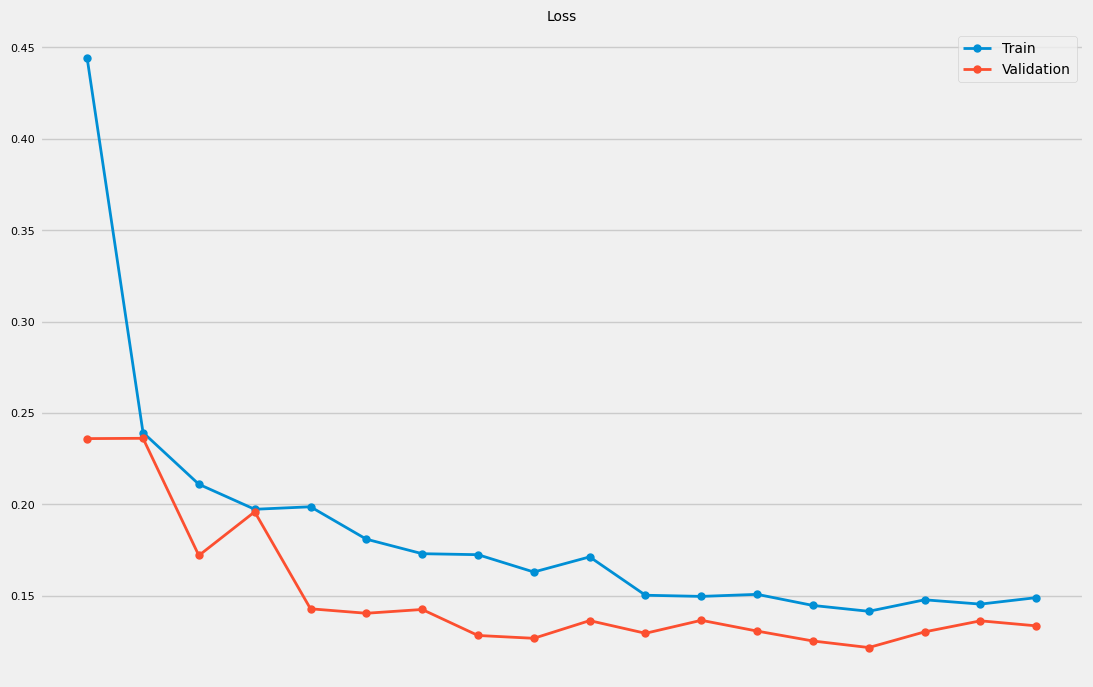

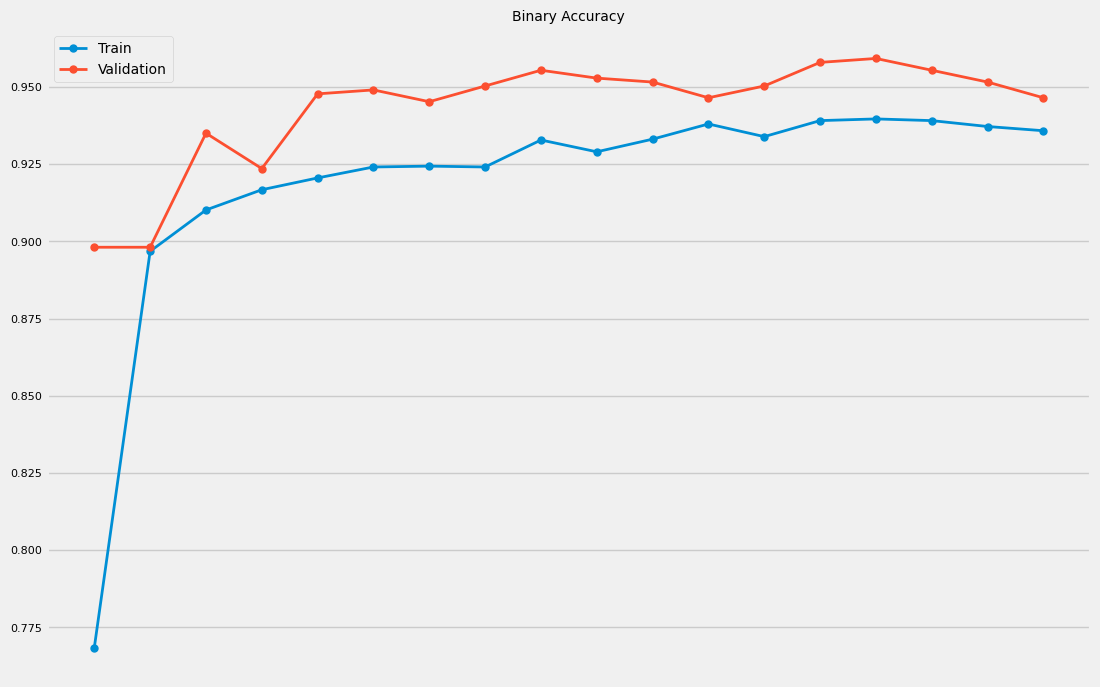

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step


<Figure size 1200x600 with 0 Axes>

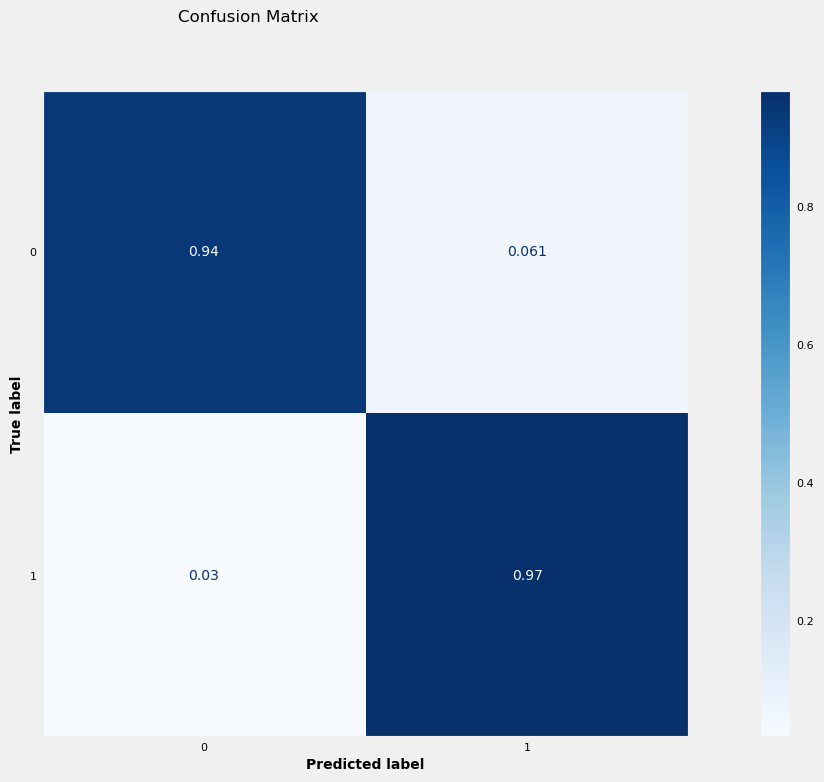

<Figure size 1200x600 with 0 Axes>

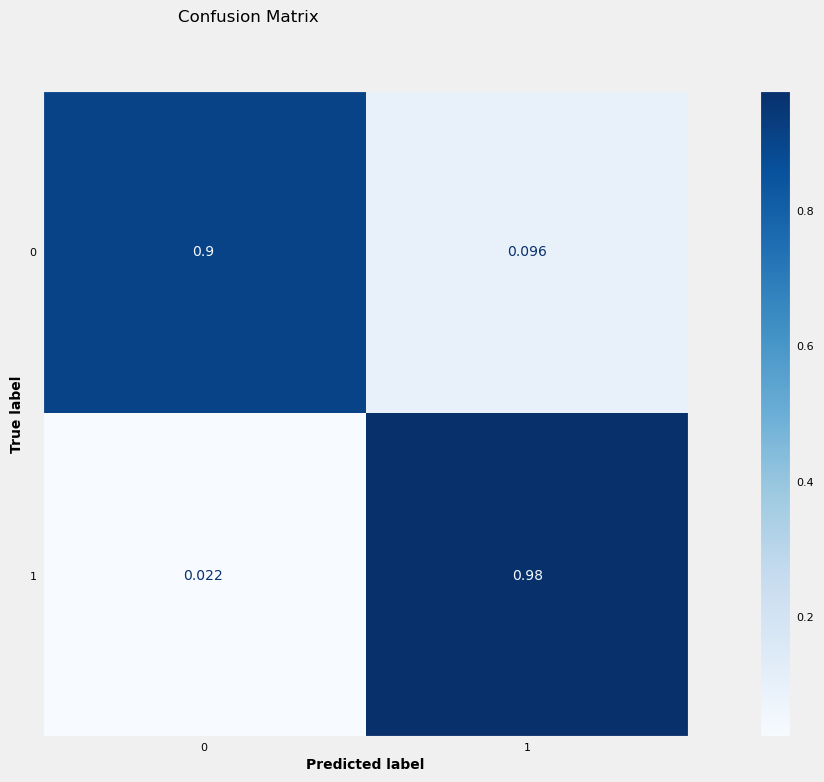

Training set accuracy:   0.962
Test set accuracy:       0.961
Training set
Class 0: precision=0.916, recall=0.939, f1_score=0.928
Class 1: precision=0.979, recall=0.970, f1_score=0.975
Test set
Class 0: precision=0.929, recall=0.904, f1_score=0.916
Class 1: precision=0.970, recall=0.978, f1_score=0.974


In [43]:
history_model0_df = pd.DataFrame(history_model0.history)
plot_measure(history_model0_df.loss, history_model0_df.val_loss, "Loss")
plot_measure(history_model0_df.binary_accuracy, history_model0_df.val_binary_accuracy, "Binary Accuracy")

model0.load_weights(model_file)
predictions_train_model0 = np.rint(model0.predict(X_train))
predictions_test_model0 = np.rint(model0.predict(X_test))

plot_confusion_matrix(y_train, predictions_train_model0)
plot_confusion_matrix(y_test, predictions_test_model0)

print_accuracy_scores(y_train, y_test, predictions_train_model0, predictions_test_model0)
print_stats(y_train, predictions_train_model0, "Training set")
print_stats(y_test, predictions_test_model0, "Test set")

In [44]:
y_train_onehot = tf.keras.utils.to_categorical(y_train, 2)
y_valid_onehot = tf.keras.utils.to_categorical(y_valid, 2)
y_test_onehot = tf.keras.utils.to_categorical(y_test, 2)

f1_score = tf.keras.metrics.F1Score("weighted")
obj_f1_score = kt.Objective("val_f1_score", "max")

obj_accuracy = kt.Objective("val_accuracy", "max")


def cnn1_builder(hp):
    index = hp.Int("index", min_value=0, max_value=1, step=1)
    activation = hp.Choice("activations", activations)
    dropout_rate = hp.Choice("dropout_rate", rate)
    l2 = hp.Choice("L2", reg)
    l1 = hp.Choice("L1", reg)

    init = tf.keras.initializers.HeNormal()

    model1 = tf.keras.Sequential()

    model1.add(tf.keras.layers.InputLayer((28, 28, 1)))
    model1.add(tf.keras.layers.Rescaling(1.0 / 255))
    model1.add(tf.keras.layers.GaussianNoise(0.2))

    model1.add(tf.keras.layers.Conv2D(filters[index][0], 3, padding="same", activation=activation))
    model1.add(tf.keras.layers.MaxPool2D())

    model1.add(tf.keras.layers.Conv2D(filters[index][1], 3, padding="same", activation=activation))
    model1.add(tf.keras.layers.MaxPool2D())

    model1.add(tf.keras.layers.Conv2D(filters[index][2], 3, padding="same", activation=activation))
    model1.add(tf.keras.layers.MaxPool2D())

    model1.add(tf.keras.layers.Flatten())

    model1.add(
        tf.keras.layers.Dense(
            dense_units[index][1],
            activation,
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1, l2),
        ),
    )
    if dropout_rate > 0.0:
        model1.add(tf.keras.layers.Dropout(dropout_rate))

    model1.add(
        tf.keras.layers.Dense(
            dense_units[index][0],
            activation,
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1, l2),
        )
    )
    if dropout_rate > 0.0:
        model1.add(tf.keras.layers.Dropout(dropout_rate))

    model1.add(
        tf.keras.layers.Dense(
            2,
            "softmax",
            kernel_initializer=init,
            kernel_regularizer=tf.keras.regularizers.L1L2(l1, l2),
        )
    )

    model1.compile(optimizer="adam", loss="categorical_crossentropy", metrics=["accuracy", f1_score])

    return model1

In [45]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", mode="min", patience=3)

tuner = kt.Hyperband(cnn1_builder, obj_accuracy, seed=42, project_name="tuners/cnn1_weighted")
tuner.search(
    X_train,
    y_train_onehot,
    validation_data=(X_valid, y_valid_onehot),
    callbacks=[early_stop],
    class_weight=class_weights,
)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./tuners/cnn1_weighted/tuner0.json


In [46]:
print("Best Filter: ", filters[best_hps.get("index")])
print("Best Dense units: ", dense_units[best_hps.get("index")])
print("Best Activation Function: ", best_hps.get("activations"))

if best_hps.get("L1") > 0:
    print("Best L1 value: ", best_hps.get("L1"))

if best_hps.get("L2") > 0:
    print("Best L2 value: ", best_hps.get("L2"))

print("Best Dropout Rate: ", best_hps.get("dropout_rate"))

Best Filter:  [24, 48, 96]
Best Dense units:  [256, 512]
Best Activation Function:  leaky_relu
Best L2 value:  0.001
Best Dropout Rate:  0.5


In [47]:
model1 = tuner.hypermodel.build(best_hps)
model1.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_1 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_1                │ (None, 28, 28, 1)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 28, 28, 24)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 14, 14, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 7, 7, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 512)            │       442,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,946 (2.39 MB)

 Trainable params: 626,946 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [48]:
model_file = "./best_model/cnn1_weighted.weights.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, "val_accuracy", 1, True, True, "max")
history_model1 = model1.fit(
    X_train,
    y_train_onehot,
    epochs=100,
    validation_data=(X_valid, y_valid_onehot),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step - accuracy: 0.5609 - f1_score: 0.5866 - loss: 1.7032
Epoch 1: val_accuracy improved from -inf to 0.90955, saving model to ./best_model/cnn1_weighted.weights.h5
115/115 ━━━━━━━━━━━━━━━━━━━━ 13s 81ms/step - accuracy: 0.5619 - f1_score: 0.5876 - loss: 1.6995 - val_accuracy: 0.9096 - val_f1_score: 0.9067 - val_loss: 0.6012
Epoch 2/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8898 - f1_score: 0.8933 - loss: 0.5723
Epoch 2: val_accuracy did not improve from 0.90955
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8899 - f1_score: 0.8933 - loss: 0.5718 - val_accuracy: 0.8815 - val_f1_score: 0.8724 - val_loss: 0.4456
Epoch 3/100
107/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8945 - f1_score: 0.8978 - loss: 0.4195
Epoch 3: val_accuracy did not improve from 0.90955
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step - accuracy: 0.8948 - f1_score: 0.8982 - loss: 0.4173 - val_accuracy: 0.9070 - val_f1_score: 0.9027 - val_loss: 

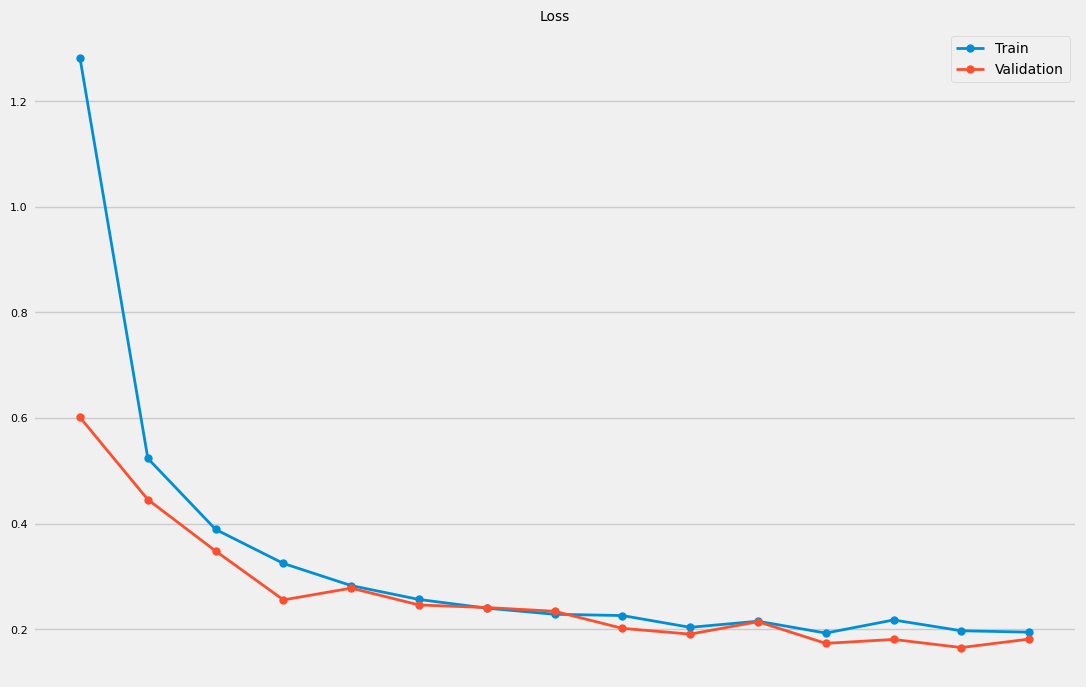

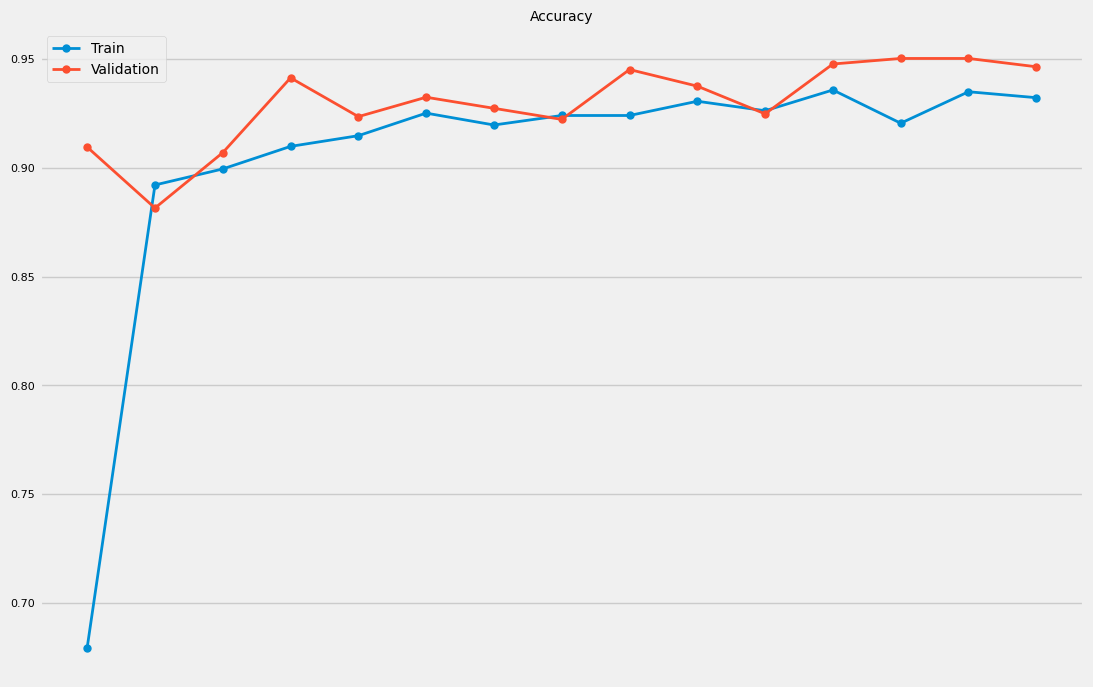

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step


<Figure size 1200x600 with 0 Axes>

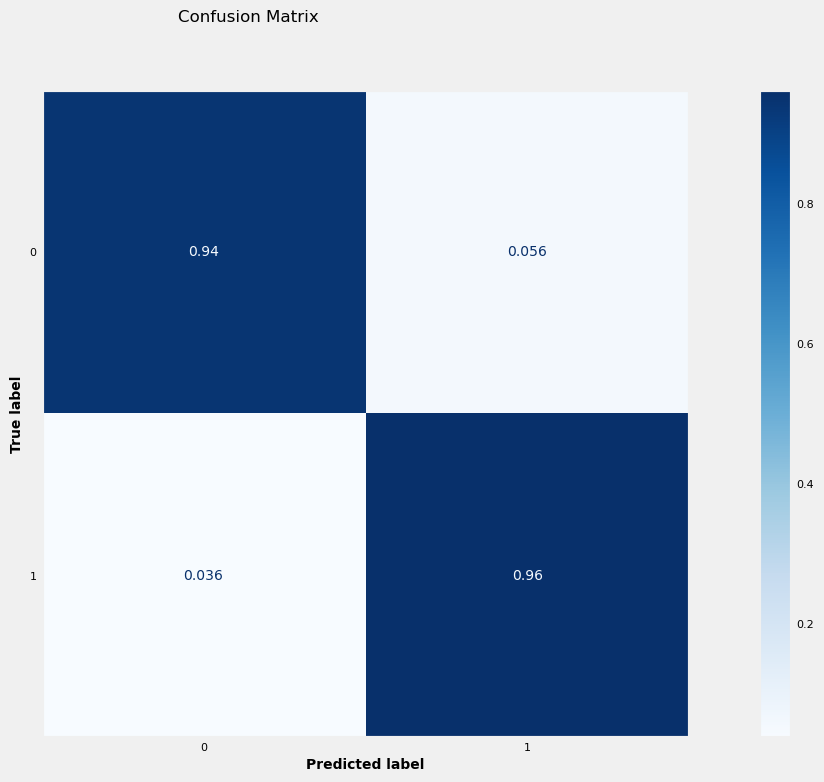

<Figure size 1200x600 with 0 Axes>

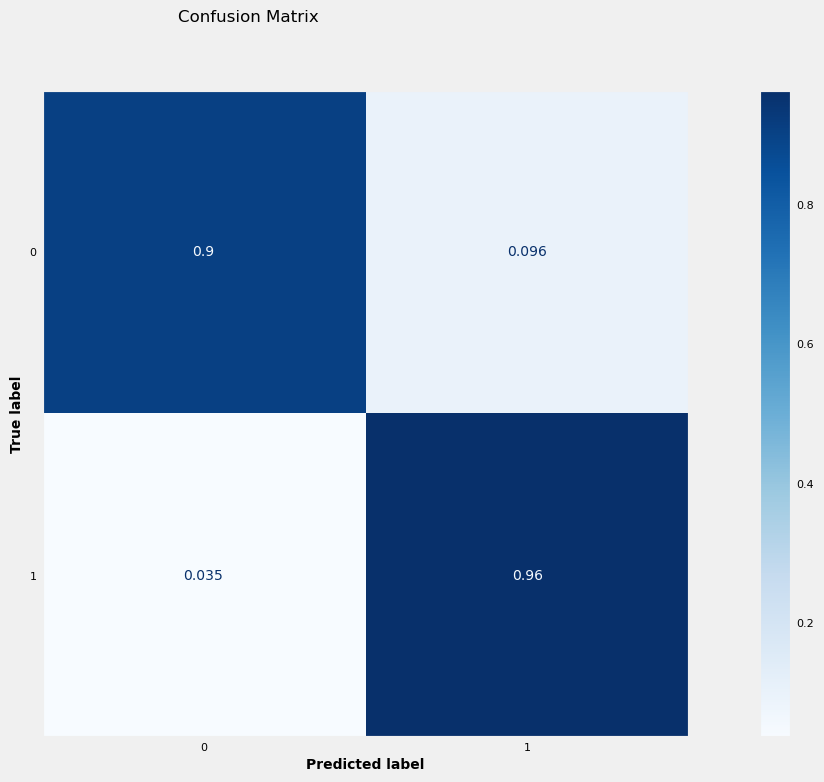

Training set accuracy:   0.958
Test set accuracy:       0.950
Training set
Class 0: precision=0.900, recall=0.944, f1_score=0.921
Class 1: precision=0.980, recall=0.964, f1_score=0.972
Test set
Class 0: precision=0.889, recall=0.904, f1_score=0.897
Class 1: precision=0.970, recall=0.965, f1_score=0.967


In [49]:
history_model1_df = pd.DataFrame(history_model1.history)
plot_measure(history_model1_df.loss, history_model1_df.val_loss, "Loss")
plot_measure(history_model1_df.accuracy, history_model1_df.val_accuracy, "Accuracy")

model1.load_weights(model_file)
predictions_train_model1 = np.argmax(model1.predict(X_train), axis=-1)
predictions_test_model1 = np.argmax(model1.predict(X_test), axis=-1)

plot_confusion_matrix(y_train, predictions_train_model1)
plot_confusion_matrix(y_test, predictions_test_model1)

print_accuracy_scores(y_train, y_test, predictions_train_model1, predictions_test_model1)
print_stats(y_train, predictions_train_model1, "Training set")
print_stats(y_test, predictions_test_model1, "Test set")

In [50]:
early_stop = tf.keras.callbacks.EarlyStopping(monitor="loss", mode="min", patience=5)

tuner = kt.Hyperband(cnn1_builder, obj_f1_score, seed=42, project_name="tuners/cnn1_weighted_f1")
tuner.search(
    X_train,
    y_train_onehot,
    validation_data=(X_valid, y_valid_onehot),
    callbacks=[early_stop],
    class_weight=class_weights,
)
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

Reloading Tuner from ./tuners/cnn1_weighted_f1/tuner0.json


In [51]:
print("Best Filter: ", filters[best_hps.get("index")])
print("Best Dense units: ", dense_units[best_hps.get("index")])
print("Best Activations Functions: ", best_hps.get("activations"))

if best_hps.get("L1") > 0:
    print("Best L1 value: ", best_hps.get("L1"))

if best_hps.get("L2") > 0:
    print("Best L2 value: ", best_hps.get("L2"))

print("Best Dropout Rate: ", best_hps.get("dropout_rate"))

Best Filter:  [24, 48, 96]
Best Dense units:  [256, 512]
Best Activations Functions:  leaky_relu
Best L2 value:  0.001
Best Dropout Rate:  0.5


In [52]:
model1 = tuner.hypermodel.build(best_hps)
model1.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling_2 (Rescaling)         │ (None, 28, 28, 1)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ gaussian_noise_2                │ (None, 28, 28, 1)      │             0 │
│ (GaussianNoise)                 │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 28, 28, 24)     │           240 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_6 (MaxPooling2D)  │ (None, 14, 14, 24)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 14, 14, 48)     │        10,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_7 (MaxPooling2D)  │ (None, 7, 7, 48)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_8 (Conv2D)               │ (None, 7, 7, 96)       │        41,568 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_8 (MaxPooling2D)  │ (None, 3, 3, 96)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 864)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 512)            │       442,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_4 (Dropout)             │ (None, 512)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 256)            │       131,328 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_5 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 626,946 (2.39 MB)

 Trainable params: 626,946 (2.39 MB)

 Non-trainable params: 0 (0.00 B)

In [53]:
model_file = "./best_model/cnn1_weighted_f1.weights.h5"
checkpoint = tf.keras.callbacks.ModelCheckpoint(model_file, "val_f1_score", 1, True, True, "max")
history_model1 = model1.fit(
    X_train,
    y_train_onehot,
    epochs=100,
    validation_data=(X_valid, y_valid_onehot),
    callbacks=[early_stop, checkpoint],
    class_weight=class_weights,
)

Epoch 1/100
115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step - accuracy: 0.6039 - f1_score: 0.7542 - loss: 1.7127
Epoch 1: val_f1_score improved from -inf to 0.92647, saving model to ./best_model/cnn1_weighted_f1.weights.h5
115/115 ━━━━━━━━━━━━━━━━━━━━ 11s 72ms/step - accuracy: 0.6050 - f1_score: 0.7544 - loss: 1.7090 - val_accuracy: 0.9274 - val_f1_score: 0.9265 - val_loss: 0.6664
Epoch 2/100
110/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.8824 - f1_score: 0.8868 - loss: 0.6247
Epoch 2: val_f1_score improved from 0.92647 to 0.93265, saving model to ./best_model/cnn1_weighted_f1.weights.h5
115/115 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - accuracy: 0.8831 - f1_score: 0.8874 - loss: 0.6216 - val_accuracy: 0.9338 - val_f1_score: 0.9326 - val_loss: 0.4240
Epoch 3/100
111/115 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.9066 - f1_score: 0.9097 - loss: 0.4274
Epoch 3: val_f1_score improved from 0.93265 to 0.93648, saving model to ./best_model/cnn1_weighted_f1.weights.h5
115/115 ━━━━━━━━━━━━━━━━━

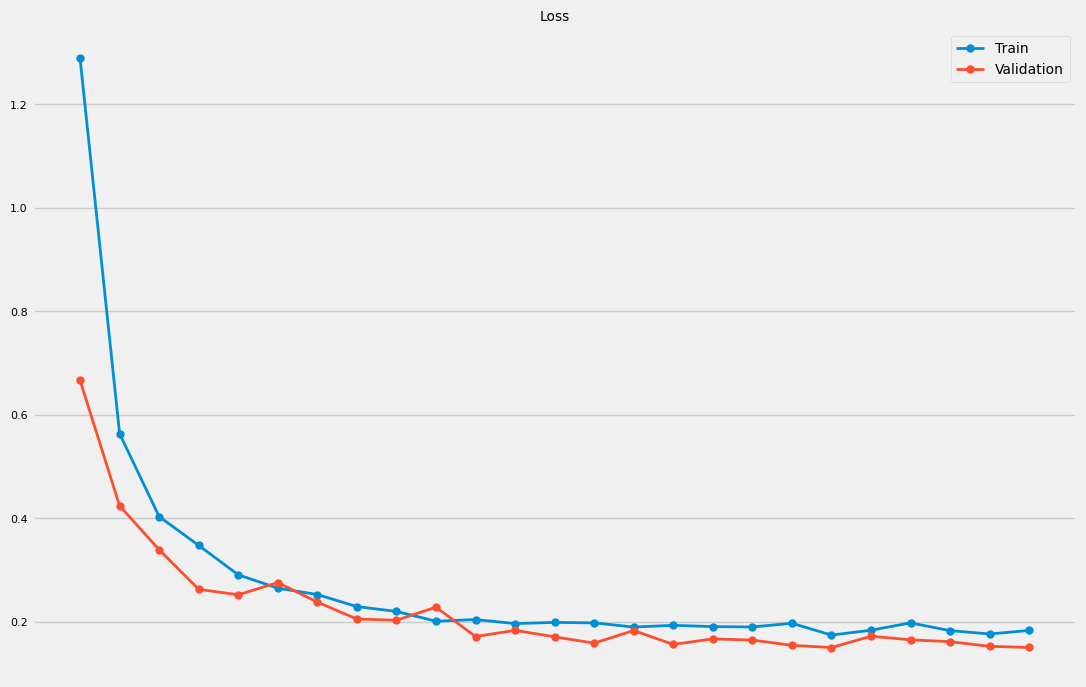

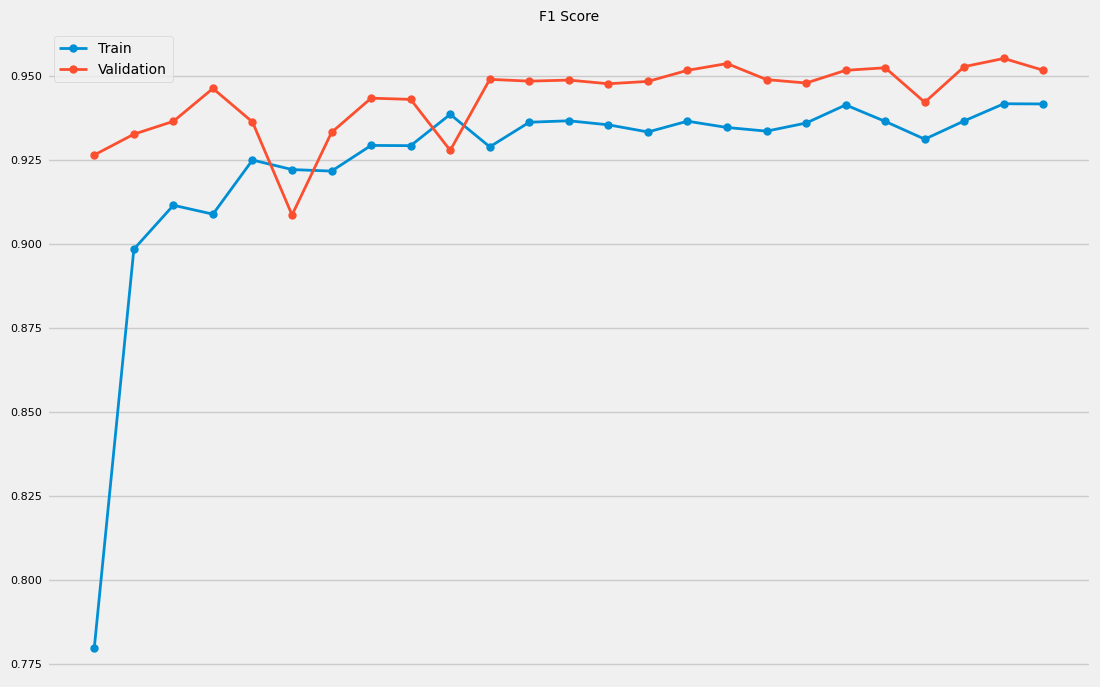

115/115 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


<Figure size 1200x600 with 0 Axes>

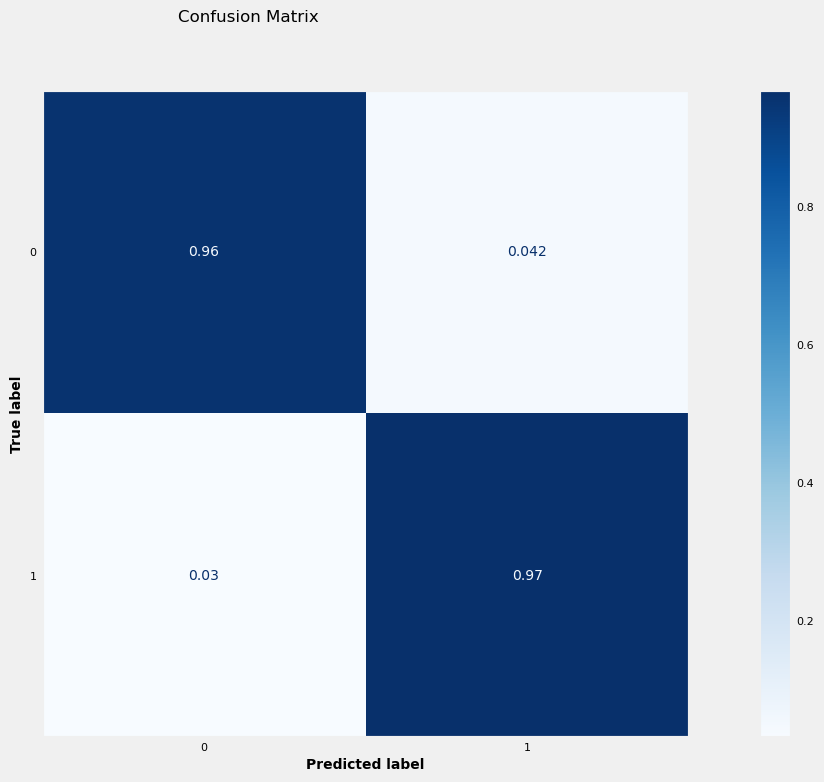

<Figure size 1200x600 with 0 Axes>

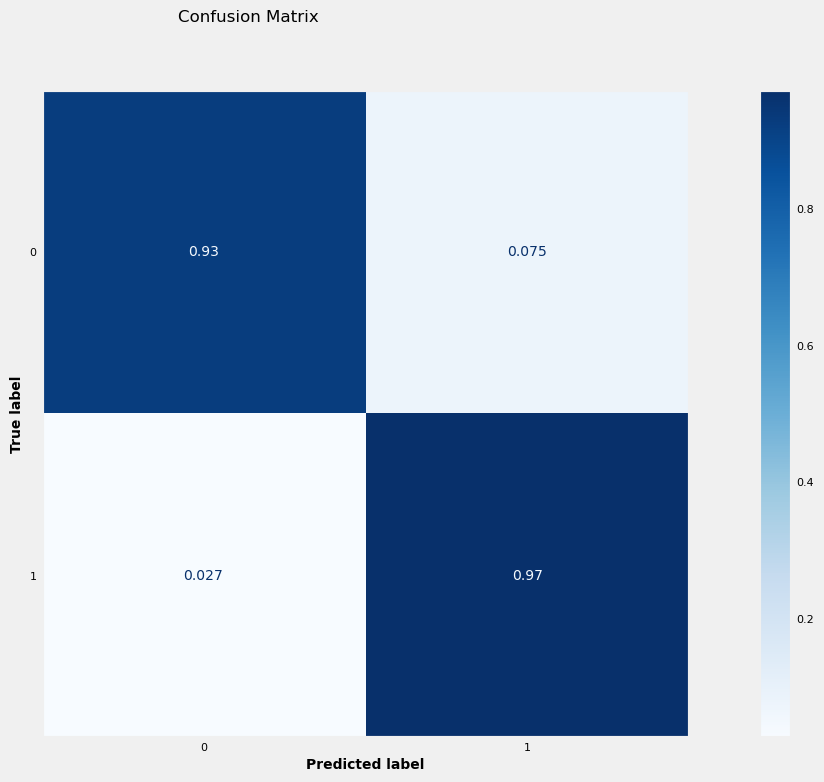

Training set accuracy:   0.967
Test set accuracy:       0.962
Training set
Class 0: precision=0.918, recall=0.958, f1_score=0.937
Class 1: precision=0.985, recall=0.970, f1_score=0.978
Test set
Class 0: precision=0.915, recall=0.925, f1_score=0.920
Class 1: precision=0.977, recall=0.973, f1_score=0.975


In [54]:
history_model1_df = pd.DataFrame(history_model1.history)
plot_measure(history_model1_df.loss, history_model1_df.val_loss, "Loss")
plot_measure(history_model1_df.f1_score, history_model1_df.val_f1_score, "F1 Score")

model1.load_weights(model_file)
predictions_train_model1 = np.argmax(model1.predict(X_train), axis=-1)
predictions_test_model1 = np.argmax(model1.predict(X_test), axis=-1)

plot_confusion_matrix(y_train, predictions_train_model1)
plot_confusion_matrix(y_test, predictions_test_model1)

print_accuracy_scores(y_train, y_test, predictions_train_model1, predictions_test_model1)
print_stats(y_train, predictions_train_model1, "Training set")
print_stats(y_test, predictions_test_model1, "Test set")

In tutti i 3 tuning i filtri dei layer Conv2D e il numero di nodi dei layer Dense è stato lo stesso.

Per cnn0 non è stato utilizzati la regolarizzazione e il dropout rate è stato 0.2.

Per i 2 tuning di cnn1 si è ottenuto lo stesso risultato, dropout rate pari a 0.5 e L2 pari a 0.001. Nonostante si sia ottenuta la stessa rete i risultati differiscono di non poco e ciò dipende da Tensorflow. Impostare il seed non è sufficiente infatti andrebbe utilizzata l'opzione sperimentale tf.config.experimental.enable_op_determinism(), che non è ancora disponibile per il layer MaxPool2D.